In [1]:
#standard libraries
import numpy as np
import pandas as pd

#visualization libraries
import seaborn as sns
import matplotlib as plt

#model learning libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

#hyperparameters
from sklearn.model_selection import cross_val_score
import optuna
from optuna import Trial, study, samplers

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/motorica-skillfactory-internship-test-2024-07/sample_submission.csv
/kaggle/input/motorica-skillfactory-internship-test-2024-07/y_train.csv
/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_test.npy
/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_train.npy


#### Data Familiarization

In [3]:
#load the data set
X_train_narray = np.load('/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_train.npy')
X_test_narray = np.load('/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_test.npy')
sample_submission = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-2024-07/sample_submission.csv')

In [4]:
#display the dimensions
print(X_train_narray.shape, X_test_narray.shape, sep=', ')

(323, 40, 100), (54, 40, 100)


#### Representation of the Target Variable

In [5]:
#load the predictive set
y_train = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-2024-07/y_train.csv')

In [6]:
#display the predictive dimensions
y_train.shape

(32300, 2)

In [7]:
#display the predictive train set
y_train.head()

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0


In [8]:
#check that there are no null values in the data set
y_train.isnull().sum()[y_train.isnull().sum() > 0]

Series([], dtype: int64)

`y_train.csv` содержит следующие классы: 

  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab"

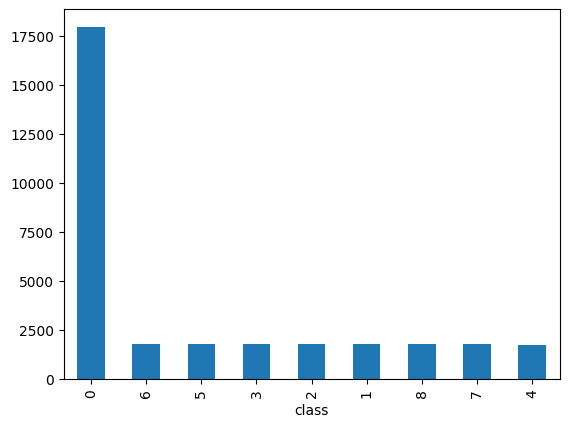

In [9]:
#class types
round(y_train['class'].value_counts(normalize=True) * 100, 2).sort_values()

y_train['class'].value_counts().plot(kind='bar');

#### Convert an Array into a DataFrame

In [10]:
#train set
X_train = pd.DataFrame(columns=[f'{i}'for i in range(X_train_narray.shape[1])])
for i in range(len(X_train_narray)):
    X_train = pd.concat([X_train, pd.DataFrame(X_train_narray[i].T,
                                               columns=[f'{i}'for i in range(X_train_narray.shape[1])])],
                        ignore_index=True)

#test set
X_test = pd.DataFrame(columns=[f'{i}'for i in range(X_test_narray.shape[1])])
for i in range(len(X_test_narray)):
    X_test = pd.concat([X_test, pd.DataFrame(X_test_narray[i].T,
                                             columns=[f'{i}'for i in range(X_test_narray.shape[1])])],
                       ignore_index=True)

/tmp/ipykernel_18/641351009.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train = pd.concat([X_train, pd.DataFrame(X_train_narray[i].T,
/tmp/ipykernel_18/641351009.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_test = pd.concat([X_test, pd.DataFrame(X_test_narray[i].T,


In [11]:
#display the new dimensions
X_train.shape, X_test.shape

((32300, 40), (5400, 40))

In [12]:
print(f'the split: train - {round(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100, 0)}%, test - {round(X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100, 0)}%')

the split: train - 86.0%, test - 14.0%


In [13]:
#display the train data set
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0
2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,1878.0,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0
3,1120.0,10.0,1440.0,59.0,32.0,1730.0,143.0,6.0,1066.0,13.0,...,1876.0,68.0,13.0,1165.0,131.0,29.0,1667.0,24.0,726.0,34.0
4,1115.0,16.0,1437.0,51.0,30.0,1724.0,138.0,4.0,1062.0,12.0,...,1872.0,73.0,9.0,1165.0,133.0,29.0,1667.0,32.0,724.0,24.0


#### Visualization

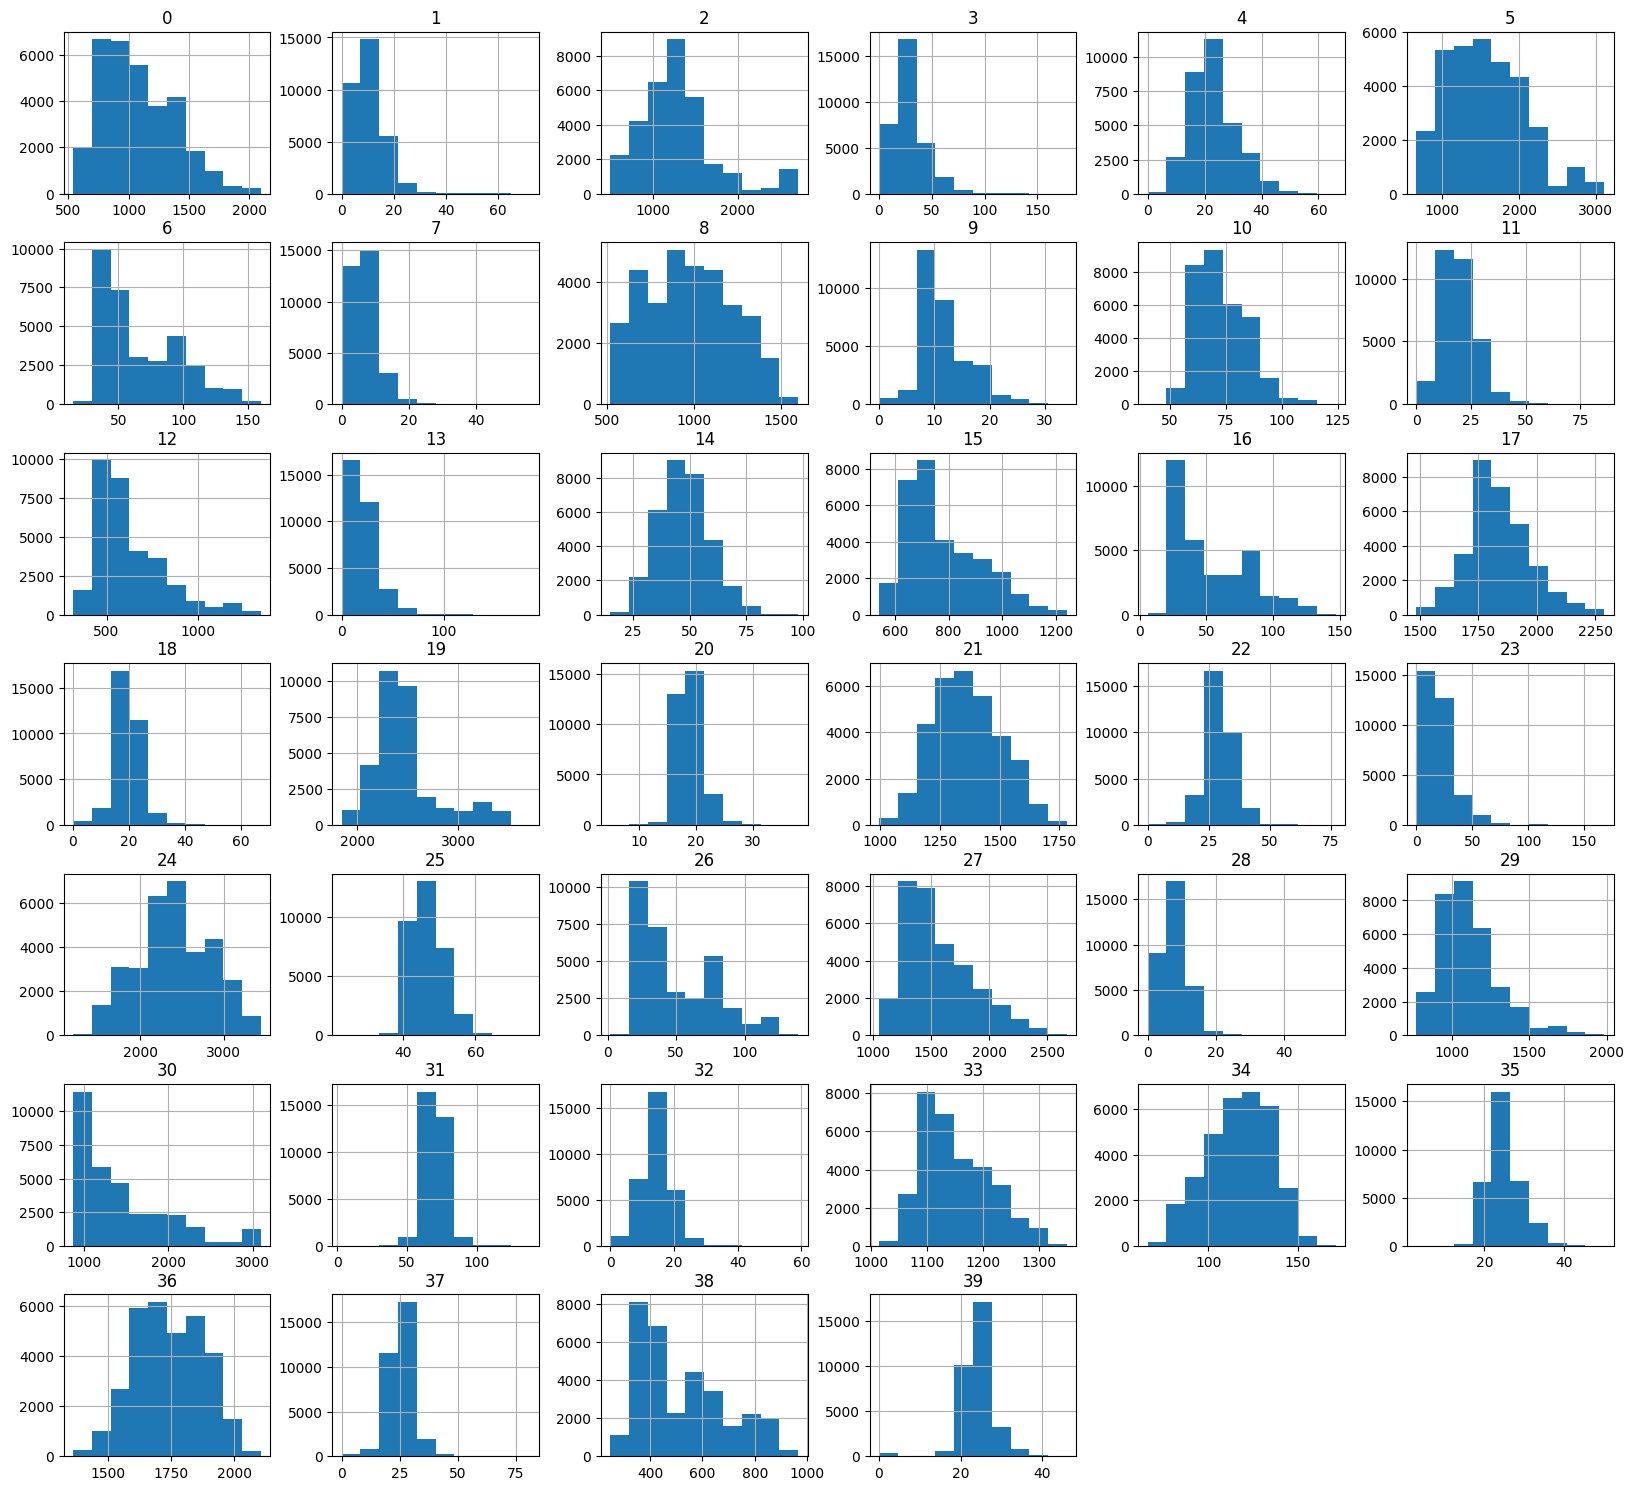

In [14]:
#create a histogram to show the distribution of numerical features
X_train.hist(figsize=(20, 18.5));

In [15]:
#show the basic descriptive statistics
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,...,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000,32300.000000
mean,1080.010031,10.248885,1282.964737,28.563994,23.041269,1572.169876,66.113344,6.691146,976.046873,11.724768,...,1449.424180,69.892291,14.287523,1151.938607,116.753746,24.823746,1741.236378,25.751517,522.477276,23.774241
std,298.128816,6.506902,437.590318,15.733459,7.911239,497.383955,29.852017,4.701581,247.630096,4.357266,...,535.675785,8.076322,5.161231,61.085345,17.736049,4.121546,136.014045,5.689679,165.799217,4.021698
min,538.000000,0.000000,492.000000,0.000000,0.000000,662.000000,15.000000,0.000000,518.000000,0.000000,...,870.000000,3.000000,0.000000,1014.000000,66.000000,3.000000,1362.000000,0.000000,249.000000,0.000000
25%,834.000000,6.000000,993.000000,18.000000,17.000000,1172.000000,41.000000,4.000000,770.000000,9.000000,...,1039.000000,65.000000,11.000000,1103.000000,105.000000,22.000000,1638.000000,23.000000,384.000000,22.000000
50%,1019.000000,10.000000,1230.500000,26.000000,22.000000,1542.000000,53.000000,6.000000,971.000000,11.000000,...,1275.000000,70.000000,14.000000,1140.000000,118.000000,24.000000,1735.000000,26.000000,465.000000,23.000000
75%,1297.000000,14.000000,1460.000000,35.000000,28.000000,1924.000000,91.000000,9.000000,1162.000000,14.000000,...,1753.000000,74.000000,17.000000,1198.000000,130.000000,27.000000,1856.000000,28.000000,629.000000,25.000000
max,2098.000000,72.000000,2715.000000,178.000000,66.000000,3109.000000,160.000000,56.000000,1597.000000,34.000000,...,3099.000000,138.000000,59.000000,1350.000000,171.000000,50.000000,2105.000000,81.000000,965.000000,46.000000


In [16]:
#show the basic descriptive statistics
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,...,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000,5400.000000
mean,1050.978704,11.676111,1197.300741,30.328519,28.809444,1485.755741,81.440741,6.500741,950.107037,13.213889,...,1352.212963,72.203889,14.070185,1159.929074,123.828889,25.194074,1818.200556,25.937963,506.646296,24.635926
std,320.314581,6.479004,478.746999,14.561589,9.045817,521.099273,34.071254,4.629643,277.614835,5.051723,...,537.844671,7.639916,5.017775,69.850392,16.657894,4.307125,138.043558,5.550559,184.749576,4.099391
min,534.000000,0.000000,440.000000,0.000000,0.000000,635.000000,14.000000,0.000000,502.000000,0.000000,...,840.000000,18.000000,0.000000,1021.000000,81.000000,9.000000,1493.000000,0.000000,233.000000,0.000000
25%,772.000000,8.000000,775.750000,20.000000,22.000000,1048.000000,59.000000,4.000000,712.500000,10.000000,...,951.000000,68.000000,11.000000,1104.000000,113.000000,22.000000,1712.000000,23.000000,352.000000,23.000000
50%,964.000000,12.000000,1151.000000,28.000000,29.000000,1414.000000,66.000000,6.000000,915.000000,12.000000,...,1180.500000,72.000000,14.000000,1157.000000,124.000000,24.000000,1836.000000,26.000000,436.000000,24.000000
75%,1339.000000,16.000000,1474.250000,37.000000,33.000000,1887.000000,104.000000,9.000000,1179.000000,16.000000,...,1528.000000,77.000000,17.000000,1206.000000,133.000000,28.000000,1918.000000,29.000000,637.000000,26.000000
max,1925.000000,72.000000,2674.000000,129.000000,59.000000,3026.000000,184.000000,51.000000,1644.000000,35.000000,...,3130.000000,129.000000,56.000000,1352.000000,165.000000,41.000000,2091.000000,68.000000,976.000000,42.000000


#### Encoding Features

In [17]:
#initialize the normalizer
mm_scaler = preprocessing.MinMaxScaler()

#encode the features
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.fit_transform(X_test)

In [18]:
#confirm the dimensions
X_train_scaled.shape, X_test_scaled.shape

((32300, 40), (5400, 40))

In [19]:
#select the features
y_train = y_train['class']

#### Model Learning with Random Forest

In [20]:
#use the Optuna method to look for best hyper parameters
def optuna_rf(trial):
  #set hyperparameters
  n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 125, 150, 175, 200])
  max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, 15, 20])
  min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 3, 4, 5])
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  
  #use the combinations for model build
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          criterion=criterion,
                                          max_features=max_features,
                                          random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X=X_train_scaled,
    y=y_train,
    cv=5,
    scoring='f1_micro', 
    n_jobs=-1).mean()

  return score

In [21]:
%%time
#begin hyperparameters selection
#create review object
study_optuna = optuna.create_study(study_name='RandomForestClassifier',
                                   direction='maximize')

#search for the best combination
study_optuna.optimize(optuna_rf, n_trials=20)

[I 2024-07-24 22:17:07,564] A new study created in memory with name: RandomForestClassifier
[I 2024-07-24 22:17:59,879] Trial 0 finished with value: 0.7462848297213623 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': None}. Best is trial 0 with value: 0.7462848297213623.
[I 2024-07-24 22:18:23,989] Trial 1 finished with value: 0.7658513931888544 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 1 with value: 0.7658513931888544.
[I 2024-07-24 22:22:24,063] Trial 2 finished with value: 0.7016099071207431 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_features': None}. Best is trial 1 with value: 0.7658513931888544.
[I 2024-07-24 22:26:22,888] Trial 3 finished with value: 0.7519814241486068 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 4, 'criterio

CPU times: user 6.15 s, sys: 2.36 s, total: 8.51 s
Wall time: 20min


In [22]:
#display results for train data
print('train data:')
print(f'f1 score: {study_optuna.best_value:.3f}')
print(f'hyperparameters for random forest with optuna {study_optuna.best_params}')

train data:
f1 score: 0.791
hyperparameters for random forest with optuna {'n_estimators': 125, 'max_depth': 10, 'min_samples_leaf': 5, 'criterion': 'entropy', 'max_features': 'log2'}


In [23]:
#find the metrics for test data
model_opt_rf = ensemble.RandomForestClassifier(**study_optuna.best_params,
                                               random_state=42,
                                               )

In [24]:
#model learning
model_opt_rf.fit(X_train_scaled, y_train)

#make a prediction
y_train_pred = model_opt_rf.predict(X_train_scaled)

В качестве метрики оценки качества решения выбран Mean F-Score.

In [25]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred, average="micro"):.3f}')
print(f'accuracy: {model_opt_rf.score(X_train_scaled, y_train):.3f}')

train data:
f1_score: 0.866
accuracy: 0.866


In [26]:
#check whether optimization is moving in the right direction by display the number of trials on x-axis and the metrics on y_axis
optuna.visualization.plot_optimization_history(study_optuna,
                                               target_name='f1_score = micro')

In [27]:
#find which hyperparameters contribute the most to the maximization of the metric 
optuna.visualization.plot_param_importances(study_optuna,
                                            target_name='f1_score')

In [28]:
#highlight the relationship between different hyperparameter combinations and the metric value for these combinations
optuna.visualization.plot_contour(study_optuna,
                                  params=['max_depth', 'max_features'],
                                  target_name='f1_score')

#### Model Learning with Gradient Boosting

In [29]:
#use the Optuna method to look for best hyper parameters
def optuna_gb(trial):
  #set hyperparameters
  params = {
    "n_estimators": trial.suggest_categorical('n_estimators', [100, 150, 200]),
    "learning_rate": trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2]),    
    "max_depth": trial.suggest_categorical('max_depth', [3, 5, 7]),
    "max_features": trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    "min_samples_leaf": trial.suggest_categorical('min_samples_leaf', [2, 3, 4, 5]),
    "loss" : "log_loss",
    "random_state": 42,
    }

  #use the combinations for model build
  model = ensemble.GradientBoostingClassifier(**params)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X=X_train_scaled,
    y=y_train,
    cv=5,
    scoring='f1_micro',
    n_jobs=-1).mean()

  return score

In [30]:
%%time
#begin hyperparameters selection
#create review object
study_optuna = optuna.create_study(study_name='GradientBoostingClassifier',
                                   direction='maximize')

#search for the best combination
study_optuna.optimize(optuna_gb, n_trials=20)

[I 2024-07-24 22:37:21,502] A new study created in memory with name: GradientBoostingClassifier
[I 2024-07-24 22:39:49,735] Trial 0 finished with value: 0.7452012383900929 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7452012383900929.
[I 2024-07-24 22:41:54,188] Trial 1 finished with value: 0.7451083591331269 and parameters: {'n_estimators': 150, 'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7452012383900929.
[I 2024-07-24 22:44:43,916] Trial 2 finished with value: 0.5557275541795665 and parameters: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7452012383900929.
[I 2024-07-24 22:47:51,089] Trial 3 finished with value: 0.5557275541795665 and parameters: {'n_estimators': 150, 'learning_rate': 0.001, 'max_depth': 5, 'ma

CPU times: user 17 s, sys: 7.21 s, total: 24.2 s
Wall time: 58min 32s


In [31]:
#display results for train data
print('train data:')
print(f'f1 score: {study_optuna.best_value:.3f}')
print(f'hyperparameters for gradient boosting with optuna {study_optuna.best_params}')

train data:
f1 score: 0.768
hyperparameters for gradient boosting with optuna {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3}


In [32]:
#find the metrics for test data
model_opt_gb = ensemble.GradientBoostingClassifier(**study_optuna.best_params,
                                                   random_state=42,
                                                   )

In [33]:
#model learning
model_opt_gb.fit(X_train_scaled, y_train)

#make a prediction
y_train_pred_gb = model_opt_gb.predict(X_train_scaled)

In [34]:
#display the metrics
print('train data:')
print(f'f1_score: {metrics.f1_score(y_train, y_train_pred_gb, average="micro"):.3f}')
print(f'accuracy: {model_opt_gb.score(X_train_scaled, y_train):.3f}')

train data:
f1_score: 0.853
accuracy: 0.853


#### Prediction Submission

In [35]:
#make a prediction
predict_submission = model_opt_rf.predict(X_test_scaled)

In [36]:
#set submission to predictive set
sample_submission['class'] = predict_submission

In [37]:
#save the predictive results
sample_submission.to_csv('competition_submission.csv', index=False)

In [38]:
sample_submission.head(10)

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
5,323-5,4
6,323-6,4
7,323-7,4
8,323-8,4
9,323-9,4
